# CTFT->DTFT->DFT->FFT

 - https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html
 - http://eceweb1.rutgers.edu/~gajic/solmanual/slides/chapter9_DFT.pdf

`CTFT` $X(j\omega)$ can be approximated using [Riemann sum](https://brilliant.org/wiki/riemann-sums/):

$$
\begin{align*}
X(j\omega) &= \int_{-\infty}^{\infty} x(t)e^{-j\omega t} dt \\
           &= \lim_{T_s \to 0} T_s\sum_{k=-\infty}^{\infty} x(kT_s)e^{-j\omega kT_s}
\end{align*}
$$

Due to the discrete sampling, the item in Riemann sum becomes periodical with period $2\pi / T_s$, and it approaches infinity when Ts approaches zero. The item is exactly the `DTFT`:
$$
\text{given }  x[k] = x(kT_s) \text{ and } \Omega = \omega T_s \in  [0,2\pi) \\

DTFT\{x[k]\} = X(j\Omega) = \sum_{k=-\infty}^{\infty} x[k] e^{-jk\Omega}
$$

`DFT` is derived from DTFT by:
 - windowing x[k] so x[k]=0 for k<0 or k>=L.
 - sampling $\Omega$ in [0, $2\pi$) interval by N points (with N==L)

$$
DFT\{x[k]\} = X(\Omega_n) = \sum_{k=0}^{L-1} x[k] e^{-jk \frac{2\pi n}{N}}
$$

`FFT` is just DFT with N == L.

## Simple notation
let $e_{kn}$ denotes $e^{-j2\pi\frac{kn}{N}}$ which is function of k*n with period N, $ e_{-kn} = e_{k(N-n)} = e_{(N-k)n} $ we have:
 
$$
 X[n] = \sum_{k=0}^{N-1} x_k e_{kn} \\
 x_k = \frac{1}{N} \sum_{n=0}^{N-1} y_n e_{-kn}
$$

Since from above definition both $x_k$ and X[n] are sum of $e_{-kn}$, so we know they are all periodic signal with period N:

$$
X[n] = X[n+N] = X[n+2N] ... \\
x_k = x_{k+N} = x_{k+2N} ...
$$

When we do FFT on a signal, we are actually take a windowed segment of it and repeat that segment periodically.

## FFT of Time reversed signal is conjugate of FFT of orginal signal

$$
 X^*[n] \xtofrom{FFT} x_{-n}
$$

prove:

$$
\begin{align*}
X[n] &= \sum_k x_k e_{kn} \\
X^*[n] &= \sum_k x_k e_{-kn} = \sum_k x_k e_{(N-k)n} \\
       &\xlongequal{k'=N-k} \sum_{k'} x_{N-k'} e_{k'n} \\
       &\xtofrom{FFT} x_{N-n} = x_{-n}\\
\end{align*}
$$



## multiplication of two FFTs

$$
\begin{align*}
X[n] Y[n] &= \sum_k x_k e_{kn} \sum_p y_p e_{pn} \\
          &= \sum_k\sum_p x_k y_p e_{(k+p)n}  \\
          &= \sum_m (\sum_{k+p=m} x_k y_p) e_{mn} \\
          &\xtofrom{FFT} ( z_m = \sum_{k+p=m} x_k y_p)
\end{align*}
$$

The signal $z_m = \sum_{k+p=m} x_k y_p$ is actually convolution between signal x and y. and since x and y are all periodic functions, this is actually a `circular convolution`.

## Padding zero to x[k] = Spectrum oversampling
Since x[k] is zero outside [0,L), so by padding zero to input signal, FFT can also be used to calculate DFT with N > L, and scipy's fft function accept parameter n to do auto-padding internally. 

With that padding we have higher spectrum resolution (N is the number of samples taken from $[0,2\pi)$ period.

Inversely:
 - interpolated FFT spectrum with higher resolution would reconstruct longer x[k] with padding zeros when passed into IFFT.
 - interpolated FFT spectrum with lower resolution would reconstruct shorter x[k] when passed into IFFT.


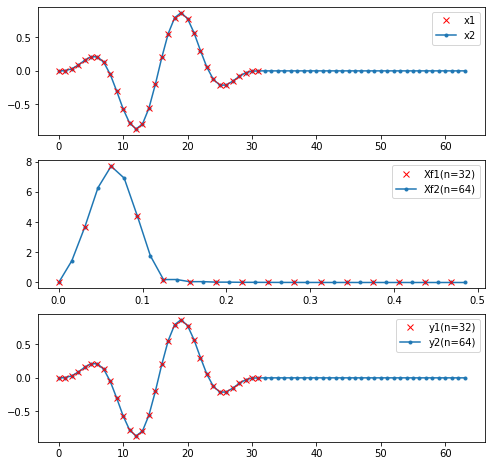

In [11]:
from scipy.fft import fft, ifft, fftfreq
from scipy import signal
import numpy as np
import IPython
import matplotlib.pyplot as plt
from vscode_audio import Audio
from lpc_helper import *
%matplotlib inline

Fs = 32
Ts = 1/Fs
def generate(t0, t1, N):
    # 1 second signal sampled at Fs sample rate
    t = np.linspace(t0, t1, Fs)
    x = np.sin(t*4*np.pi) 
    x = np.sin(t*4*np.pi) * scipy.signal.windows.hann(len(t))
    #x = scipy.signal.windows.hann(len(t))
    x = np.append(x, np.zeros(N-len(x)))
    Xf = fft(x)
    f = fftfreq(len(Xf))[:len(Xf)//2]
    return (t,x,f,Xf)

t1,x1,f1,Xf1 = generate(0,1,32)
t2,x2,f2,Xf2 = generate(0,1,64)

plt.figure(figsize=[8,8])
plt.subplot(311)
plt.plot(x1, "xr", label="x1")
plt.plot(x2, ".-", label="x2", zorder=1)
plt.legend()

plt.subplot(312)
plt.plot(f1, np.abs(Xf1)[:len(f1)], "xr", label="Xf1(n=32)")
plt.plot(f2, np.abs(Xf2)[:len(f2)], ".-", label="Xf2(n=64)", zorder=1)
plt.legend()


plt.subplot(313)
y1 = ifft(Xf1)
y2 = ifft(Xf2)
plt.plot(y1.real, "xr", label="y1(n=32)")
plt.plot(y2.real, ".-", label="y2(n=64)", zorder=1)
plt.legend()

## Spectrum stretching = Signal Sample-rate & Length change = Discrete signal stretching in time

Let's see what will happen if we change sample rate from T1 to T2:

$$
\begin{align*}
X(j\omega) &= \int_{-\infty}^{\infty} x(t)e^{-j\omega t} dt \\
           &= \lim_{T_1 \to 0} T_1\sum_{k=-\infty}^{\infty} x(kT_1)e^{-j\omega kT_1} \\
           &= \lim_{T_2 \to 0} T_2\sum_{k=-\infty}^{\infty} x(kT_2)e^{-j\omega kT_2}
\end{align*}
$$

If both T1 & T2 is small, we have:
$$
\begin{align*}
T_1\sum_{k=-\infty}^{\infty} x(kT_1)e^{-j\omega kT_1} \approx T_2\sum_{k=-\infty}^{\infty} x(kT_2)e^{-j\omega kT_2}
\end{align*}
$$

So DTFT/DFT/FFT on same signal sampled on 2 different sample-rate is proportional under following sense:

$$
 T_1 X_1(\Omega) \approx T_2 X_2(\beta \Omega ) \ \ \ \  \beta = \frac{T_2}{T_1}
$$

So the larger sample rate would produce spectrum wider stretched in frequency.

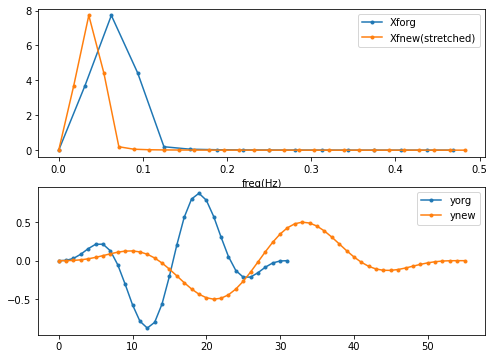

In [12]:
# Spectrum manipulation
def spman_interp(Xf):
    N = len(Xf)//2
    idx = range(N+1)
    idx_new = np.arange(0, N+1)/2
    Xfn = interp1d(idx, Xf[idx], kind='linear')(idx_new)
    Xfn[-1] = np.abs(Xfn[-1])
    return np.append(Xfn, np.conjugate(Xfn[-1:0:-1]))

def spman_stretch(Xf, ratio = 0.5):
    N = len(Xf)//2
    if (ratio < 1):
        Xfn = Xf[:int(N*ratio)+1]
    else:
        Xfn = np.append(Xf[:N+1], np.zeros(int(N*(ratio-1))))
    Xfn[-1] = np.abs(Xfn[-1])
    return np.append(Xfn, np.conjugate(Xfn[-2:0:-1]))

Xforg = Xf1
fo = fftfreq(len(Xforg))[:len(Xforg)//2]

#Xf3 = spman_interp(Xf2)
Xfnew = spman_stretch(Xforg, 1.8)
fn = fftfreq(len(Xfnew))[:len(Xfnew)//2]

plt.figure(figsize=[8,6])

ax1 = plt.subplot(211)
plt.plot(fo, np.abs(Xforg)[:len(fo)], ".-", label="Xforg")
plt.plot(fn, np.abs(Xfnew)[:len(fn)], ".-", label="Xfnew(stretched)")
ax1.set_xlabel("freq(Hz)")
plt.legend()

ax2 = plt.subplot(212)
yorg = ifft(Xforg)
ynew = ifft(Xfnew)
plt.plot(yorg.real, ".-", label="yorg")
plt.plot(ynew.real, ".-", label="ynew")

plt.legend()